# Palestine Fake News Detector - Final Model Pipeline

This notebook presents the full machine learning pipeline used for detecting fake news in Arabic texts related to Palestine. It includes all processing steps **after EDA**.

## 1. Import Libraries

In [1]:
#pip install Arabic-Stopwords

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_curve, auc, precision_score, recall_score,
    precision_recall_curve, average_precision_score
)
import seaborn as sns


import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from arabicstopwords.arabicstopwords import stopwords_list

ARABIC_STOPWORDS = set(stopwords_list())

import nltk
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 2. Load and Clean Data

In [ ]:
df = pd.read_csv("../data/raw/original_news_data.csv", encoding='utf-8')

In [4]:
def normalize_arabic(text):
    text = re.sub(r"[إأآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ؤ", "ء", text)
    text = re.sub(r"ئ", "ء", text)
    text = re.sub(r"ة", "ه", text)
    return text

def remove_diacritics(text):
    return re.sub(r'[\u064B-\u0652]', '', text)

def remove_non_arabic(text):
    return re.sub(r"[^\u0600-\u06FF\s]", " ", text)

def clean_arabic_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = remove_diacritics(text)
    text = normalize_arabic(text)
    text = remove_non_arabic(text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in ARABIC_STOPWORDS and len(t) > 1]
    return " ".join(tokens)

def clean_arabic_text_minimal(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = normalize_arabic(text)
    text = remove_non_arabic(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_outliers_iqr(df: pd.DataFrame, col: str = 'content_length') -> pd.DataFrame:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

def apply_all_cleaning(df, remove_outliers: bool = True):
    print("Standardizing columns and parsing dates...")
    df = df.rename(columns={"Id": "id", "News content": "content", "Label": "label"})
    df['date'] = pd.to_datetime(df['date'])
    df['label'] = df['label'].str.lower()

    print("Removing duplicates and filtering by date...")
    df = df.drop_duplicates(subset=['content'])
    df = df.drop_duplicates(subset=['title'])
    df = df[df['date'] >= '2023-01-01']

    print("Grouping low-frequency platforms...")
    df['platform_grouped'] = df['platform'].apply(
        lambda x: x if df['platform'].value_counts()[x] >= 30 else 'Other')
    df = df.drop(columns=['id', 'platform'])

    print("Applying aggressive Arabic text cleaning...")
    df["title_clean_agg"] = df["title"].astype(str).apply(clean_arabic_text)
    df["content_clean_agg"] = df["content"].astype(str).apply(clean_arabic_text)
    df["text_agg"] = df["title_clean_agg"] + " " + df["content_clean_agg"]

    print("Applying minimal Arabic text cleaning...")
    df["title_clean_min"] = df["title"].astype(str).apply(clean_arabic_text_minimal)
    df["content_clean_min"] = df["content"].astype(str).apply(clean_arabic_text_minimal)
    df["text_min"] = df["title_clean_min"] + " " + df["content_clean_min"]

    print("Generating feature columns...")
    df["title_length"] = df["title"].apply(lambda x: len(str(x).split()))
    df["content_length"] = df["content"].apply(lambda x: len(str(x).split()))

    if remove_outliers:
        print("Removing outliers using IQR method...")
        original_len = len(df)
        df = remove_outliers_iqr(df, col="content_length")
        print(f"Removed {original_len - len(df)} outliers")

    print("Encoding labels and platforms...")
    df['label'] = df['label'].map({'real': 0, 'fake': 1})
    df['platform_encoded'] = LabelEncoder().fit_transform(df['platform_grouped'])

    print("Data cleaning completed.")
    return df

In [5]:
df = apply_all_cleaning(df, remove_outliers=True)
df_min = df[["text_min", "label"]]
df_agg = df[["text_agg", "label"]]

Standardizing columns and parsing dates...
Removing duplicates and filtering by date...
Grouping low-frequency platforms...
Applying aggressive Arabic text cleaning...
Applying minimal Arabic text cleaning...
Generating feature columns...
Removing outliers using IQR method...
Removed 291 outliers
Encoding labels and platforms...
Data cleaning completed.


## 3. Train/Test Split

We use 80/10/10 split (train/val/test) to ensure robust training and fair evaluation.

In [6]:
X = df_min["text_min"]
y = df_min["label"]

# Stratified split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

# Combine train+val for final model
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])


## 4. Define TF-IDF Vectorizer

In [7]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))


## 5. Define Pipelines

In [8]:
pipelines = {
    "LogisticRegression": Pipeline([
        ("tfidf", tfidf),
        ("clf", LogisticRegression(max_iter=100, class_weight="balanced", random_state=42))
    ]),
    "MultinomialNB": Pipeline([
        ("tfidf", tfidf),
        ("clf", MultinomialNB())
    ]),
    "RandomForest": Pipeline([
        ("tfidf", tfidf),
        ("clf", RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("tfidf", tfidf),
        ("clf", XGBClassifier(n_estimators=100, eval_metric="logloss", scale_pos_weight=1.8, random_state=42))
    ])
}


## 6. Evaluate Models

In [9]:
results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_final, y_final, cv=5, scoring="f1")
    results[name] = {
        "f1_mean": scores.mean(),
        "f1_std": scores.std()
    }

pd.DataFrame(results).T


,f1_mean,f1_std
LogisticRegression,0.834289,0.025947
MultinomialNB,0.759709,0.031223
RandomForest,0.839930,0.018478
XGBoost,0.834038,0.014484


## 7. Best Model: XGBoost Pipeline

In [10]:
best_pipeline = pipelines["XGBoost"]
best_pipeline.fit(X_final, y_final)

y_pred = best_pipeline.predict(X_test)
y_score = best_pipeline.predict_proba(X_test)[:, 1]


## 8. Test Set Evaluation

In [11]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.90      0.93       680
           1       0.78      0.93      0.85       269

    accuracy                           0.90       949
   macro avg       0.87      0.91      0.89       949
weighted avg       0.91      0.90      0.91       949



## 9. Performance Visualizations

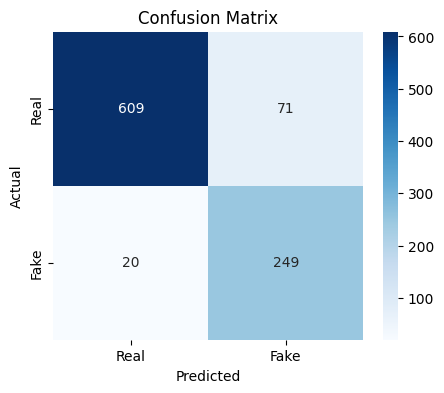

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


- The confusion matrix shows that the model correctly classified 609 real and 249 fake news samples.
- It also made 71 false positives (real predicted as fake) and 20 false negatives (fake predicted as real).
- This indicates a relatively balanced performance with more false positives than false negatives, which may be acceptable in safety-critical scenarios.


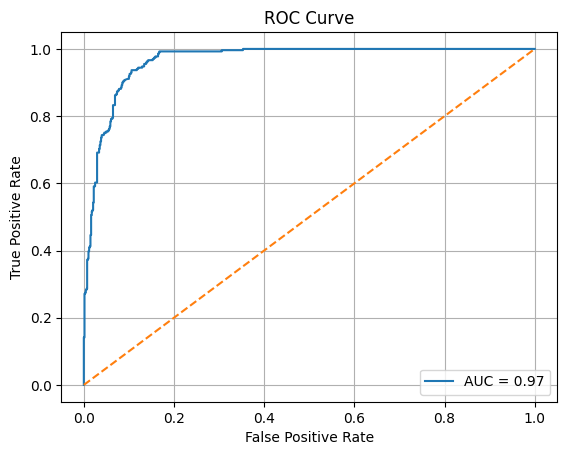

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


- The ROC curve illustrates how well the model separates the two classes.
- AUC = 0.97 indicates excellent classification capability — the model is very good at distinguishing real from fake news.


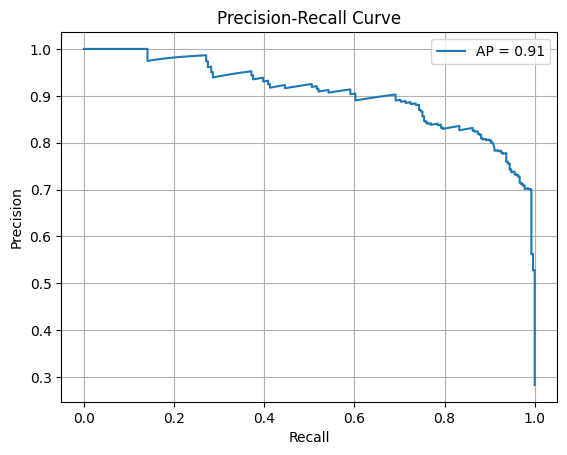

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


- This curve is especially important for imbalanced datasets.
- The average precision (AP) is 0.91, showing high model reliability when predicting positive (fake) cases.


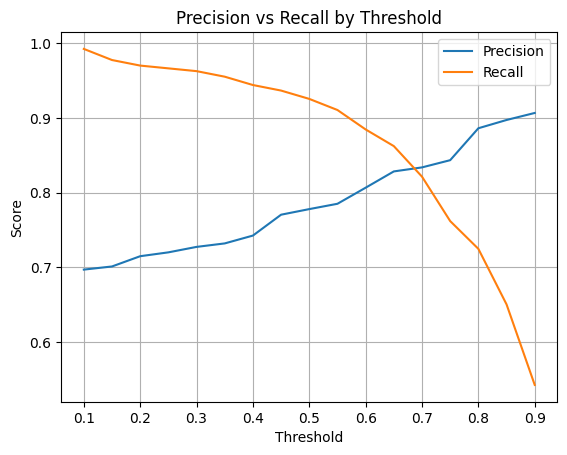

In [15]:
thresholds = np.arange(0.1, 0.91, 0.05)
precisions = []
recalls = []

for t in thresholds:
    y_thresh = (y_score > t).astype(int)
    precisions.append(precision_score(y_test, y_thresh))
    recalls.append(recall_score(y_test, y_thresh))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall by Threshold")
plt.legend()
plt.grid()
plt.show()


- This plot helps visualize the trade-off between precision and recall when changing the decision threshold.
- As the threshold increases, precision improves but recall decreases.
- You can choose a threshold that best balances your business goals.
